# Kernels in Parcels
`Parcels` provides a set of Python classes and methods to create customisable particle tracking simulations using gridded output from (ocean) circulation models. You should think of `parcels` as a *toolbox*, rather than an out-of-the-box model, where you're in control of your own simulations! In this notebook, we will focus on undestandin the role of wind in particles movements. \
From: https://parcels-code.org/blog/10year-event

## The advection kernel
Imagine you are a water parcel, with position $\mathbf{x}(t) = (x(t), y(t), z(t))$ at time $t$. You move along with the ocean flow, and hence your change in position can be described by the equation:

\begin{align*}
\frac{\text{d}\mathbf{x}(t)}{\text{d}t} = \mathbf{v}(\mathbf{x}(t),t),
\end{align*}

where $\mathbf{v}(\mathbf{x},t) = (u(\mathbf{x},t), v(\mathbf{x},t), w(\mathbf{x},t))$ describes the ocean velocity field at position $\mathbf{x}$ a time $t$.

`parcels` has the built-in Euler-forward (EE) and fourth order Runge-Kutta (RK4) schemes (ways to solve the eqation) `parcels`. Take a look in how does it look.

In [1]:
## Library imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import math
from datetime import timedelta
import inspect

import parcels

In [2]:
# Load the GlobCurrent data in the Agulhas region from the example_data
example_dataset_folder = parcels.download_example_dataset("GlobCurrent_example_data")
filenames = {
    "U": f"{example_dataset_folder}/20*.nc",
    "V": f"{example_dataset_folder}/20*.nc",
}
variables = {
    "U": "eastward_eulerian_current_velocity",
    "V": "northward_eulerian_current_velocity",
}
dimensions = {"lat": "lat", "lon": "lon", "time": "time"}
fieldset = parcels.FieldSet.from_netcdf(filenames, variables, dimensions)

In [3]:
# To get a sense of what the built-in Euler-forward scheme looks like, let's look at the source code!
print(inspect.getsource(parcels.AdvectionEE))

def AdvectionEE(particle, fieldset, time):  # pragma: no cover
    """Advection of particles using Explicit Euler (aka Euler Forward) integration."""
    (u1, v1) = fieldset.UV[particle]
    particle_dlon += u1 * particle.dt  # noqa
    particle_dlat += v1 * particle.dt  # noqa



In [4]:
# To get a sense of what the built-in RK4 scheme looks like, let's look at the source code!
print(inspect.getsource(parcels.AdvectionRK4))

def AdvectionRK4(particle, fieldset, time):  # pragma: no cover
    """Advection of particles using fourth-order Runge-Kutta integration."""
    (u1, v1) = fieldset.UV[particle]
    lon1, lat1 = (particle.lon + u1 * 0.5 * particle.dt, particle.lat + v1 * 0.5 * particle.dt)
    (u2, v2) = fieldset.UV[time + 0.5 * particle.dt, particle.depth, lat1, lon1, particle]
    lon2, lat2 = (particle.lon + u2 * 0.5 * particle.dt, particle.lat + v2 * 0.5 * particle.dt)
    (u3, v3) = fieldset.UV[time + 0.5 * particle.dt, particle.depth, lat2, lon2, particle]
    lon3, lat3 = (particle.lon + u3 * particle.dt, particle.lat + v3 * particle.dt)
    (u4, v4) = fieldset.UV[time + particle.dt, particle.depth, lat3, lon3, particle]
    particle_dlon += (u1 + 2 * u2 + 2 * u3 + u4) / 6.0 * particle.dt  # noqa
    particle_dlat += (v1 + 2 * v2 + 2 * v3 + v4) / 6.0 * particle.dt  # noqa



In [5]:
# Define initial locations to release water parcels
n_particles = 5
initial_release_lons = 26.0 * np.ones(n_particles)
initial_release_lats = np.linspace(-37.5, -34.5, n_particles)

In [6]:
# Simulation settings
runtime = timedelta(days=7)    # Total simulation time
dt = timedelta(hours=12)       # Advection timestep
outputdt = dt                  # Output timestep
chunks = int(runtime/outputdt) # Because we will store a lot of positions, to speed up our simulation we need to chunk the output datafile


In [8]:
# Initialise a particle set and output file
pset = parcels.ParticleSet(fieldset=fieldset, pclass=parcels.JITParticle,
            lon=initial_release_lons,
            lat=initial_release_lats)
pfile = pset.ParticleFile(name="output/AdvectionRK4_simulation.zarr", outputdt=outputdt, chunks=(len(pset), chunks))

# Execute the simulation using your AdvectionRK2 scheme
pset.execute(parcels.AdvectionRK4, runtime=runtime, dt=dt, output_file=pfile)

INFO: Output files are stored in output/AdvectionRK4_simulation.zarr.
100%|██████████| 604800.0/604800.0 [00:00<00:00, 2578559.93it/s]


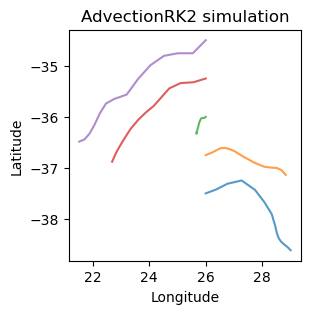

In [9]:
# Open the dataset and visualise the results
ds = xr.open_zarr("output/AdvectionRK4_simulation.zarr")
fig = plt.figure(figsize=(3,3))
plt.title('AdvectionRK2 simulation')
plt.plot(ds.lon.T, ds.lat.T, alpha=0.75)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### What about comparing advection schemes?

In [10]:
# Create lists of advection schemes and advection timesteps to test
advection_schemes = [parcels.AdvectionEE, parcels.AdvectionRK4]
dt_choices = [timedelta(hours=12), timedelta(hours=6), timedelta(hours=1), timedelta(minutes=20), timedelta(minutes=5)]

In [11]:
for advection_scheme in advection_schemes:
    for dt in dt_choices:
        pset = parcels.ParticleSet(fieldset=fieldset, pclass=parcels.JITParticle,
            lon=initial_release_lons,
            lat=initial_release_lats)
        outputdt = dt
        chunks = int(runtime/outputdt) # Because we will store a lot of positions, to speed up our simulation we need to chunk the output datafile

        pfile = pset.ParticleFile(name=f"output/{advection_scheme.__name__}_dt_{dt.seconds}s.zarr", outputdt=outputdt, chunks=(len(pset), chunks))

        print(f"Begin simulation for (scheme: {advection_scheme.__name__}, dt={dt.seconds} s)")
        pset.execute(advection_scheme, runtime=runtime, dt=dt, output_file=pfile)

Begin simulation for (scheme: AdvectionEE, dt=43200 s)
INFO: Output files are stored in output/AdvectionEE_dt_43200s.zarr.
100%|██████████| 604800.0/604800.0 [00:00<00:00, 3141917.49it/s]
Begin simulation for (scheme: AdvectionEE, dt=21600 s)
INFO: Output files are stored in output/AdvectionEE_dt_21600s.zarr.
100%|██████████| 604800.0/604800.0 [00:00<00:00, 1889281.10it/s]
Begin simulation for (scheme: AdvectionEE, dt=3600 s)
INFO: Output files are stored in output/AdvectionEE_dt_3600s.zarr.
100%|██████████| 604800.0/604800.0 [00:01<00:00, 452103.96it/s]
Begin simulation for (scheme: AdvectionEE, dt=1200 s)
INFO: Output files are stored in output/AdvectionEE_dt_1200s.zarr.
100%|██████████| 604800.0/604800.0 [00:02<00:00, 227661.13it/s]
Begin simulation for (scheme: AdvectionEE, dt=300 s)
INFO: Output files are stored in output/AdvectionEE_dt_300s.zarr.
100%|██████████| 604800.0/604800.0 [00:13<00:00, 44431.07it/s]
Begin simulation for (scheme: AdvectionRK4, dt=43200 s)
INFO: Output fil

In [12]:
# To compare the results visually, we will need distinct colour maps for each advection scheme and timestep
dt_colours = np.linspace(0,1,len(dt_choices), endpoint=True)
scheme_colours = np.linspace(0,1,len(advection_schemes), endpoint=True)

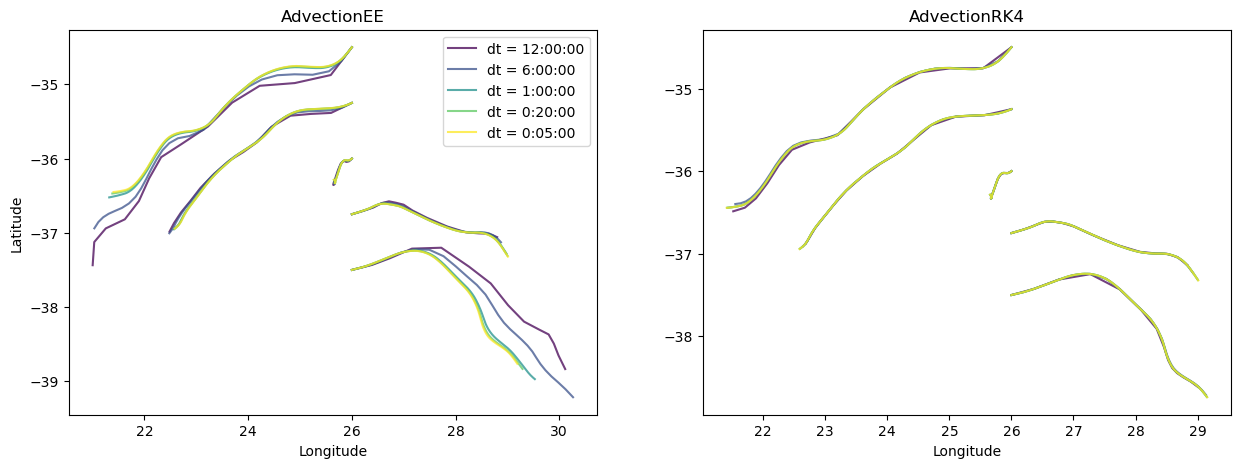

In [13]:
# Let's first compare different timesteps within each advection scheme
fig, axs = plt.subplots(nrows=1, ncols=len(advection_schemes), figsize=(15,5))
for i, advection_scheme in enumerate(advection_schemes):
    axs[i].set_title(f'{advection_scheme.__name__}')
    axs[i].set_xlabel('Longitude')
    for j,dt in enumerate(dt_choices):
        ds = xr.open_zarr(f"output/{advection_scheme.__name__}_dt_{dt.seconds}s.zarr")
        labels = [f"dt = {str(dt)}"] + [None] * (ds.lon.shape[0] - 1)
        axs[i].plot(ds.lon.T, ds.lat.T, alpha=0.75, color=plt.cm.viridis(dt_colours[j]), label=labels)
    axs[0].legend()
    axs[0].set_ylabel('Latitude')
    #plt.legend()
plt.show()

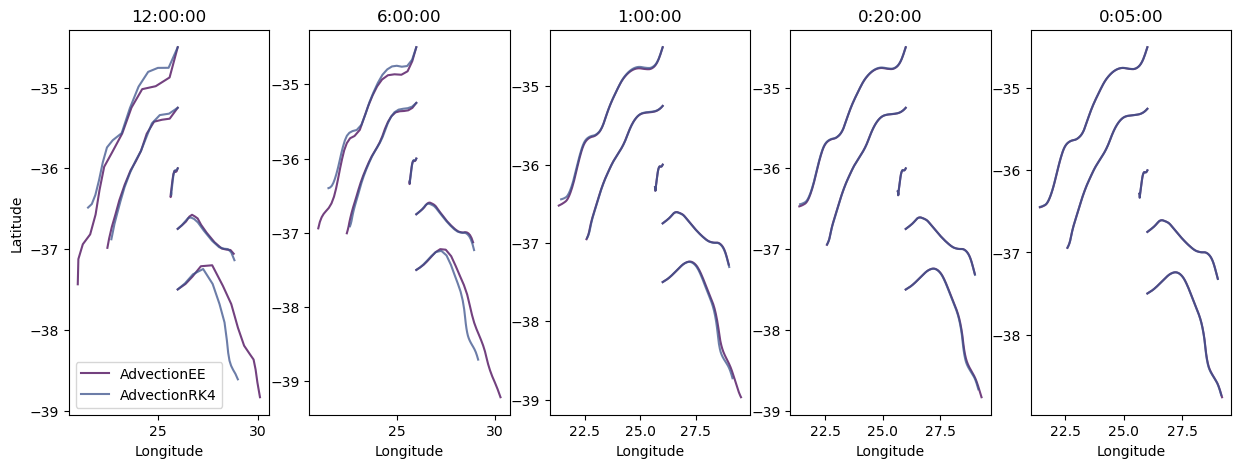

In [14]:
# Now let's compare different advection schemes with the same timestep
fig, axs = plt.subplots(nrows=1, ncols=len(dt_choices), figsize=(15,5))
for i, dt_choice in enumerate(dt_choices):
    axs[i].set_title(f'{str(dt_choice)}')
    axs[i].set_xlabel('Longitude')
    for j,advection_scheme in enumerate(advection_schemes):
        ds = xr.open_zarr(f"output/{advection_scheme.__name__}_dt_{dt_choice.seconds}s.zarr")
        labels = [f"{advection_scheme.__name__}"] + [None] * (ds.lon.shape[0] - 1)
        axs[i].plot(ds.lon.T, ds.lat.T, alpha=0.75, color=plt.cm.viridis(dt_colours[j]), label=labels)
    axs[0].legend()
    axs[0].set_ylabel('Latitude')
    #plt.legend()
plt.show()

## Developing a wind-drift kernel
A buoyant particle of finite size that floats on the ocean surface may experience a drift induced by wind. In the second part of this notebook, we will develop a number of wind-drift kernels.

A simple equation to describe the velocity of a particle that may experience wind-induced drift is $\mathbf{v}_\text{p} = \mathbf{u} + \alpha \mathbf{u}_\text{w}$, where $\mathbf{u}$ is the ocean velocity, $\mathbf{u}_\text{w}$ is the wind velocity, and $\alpha$ is the windage coefficient. Let's construct a kernel that models just the second half of this equation (as we can use the built-in `parcels` advection kernels to model the first half!).

In [15]:
# Reconstruct our fieldset:
fieldset = parcels.FieldSet.from_netcdf(filenames, variables, dimensions)

# Create an idealised wind field and add it to the fieldset
xdim, ydim = (len(fieldset.U.lon), len(fieldset.U.lat))
UWind = parcels.Field(
    "UWind",
    np.ones((ydim, xdim), dtype=np.float32) * np.sin(fieldset.U.lat)[:, None],
    lon=fieldset.U.lon,
    lat=fieldset.U.lat,
    mesh="spherical",
    fieldtype="U",
)
VWind = parcels.Field(
    "VWind", np.zeros((ydim, xdim), dtype=np.float32), grid=UWind.grid, fieldtype="V"
)
fieldset_wind = parcels.FieldSet(UWind, VWind)

fieldset.add_field(fieldset_wind.U, name="UWind")
fieldset.add_field(fieldset_wind.V, name="VWind")

In [16]:
# Define a custom particle class that includes a windage factor and angle
WindParticle = parcels.JITParticle
WindParticle = WindParticle.add_variable("windage_coefficient", np.float64)
WindParticle = WindParticle.add_variable("windangle", np.float64)

#setattr(WindParticle, "windage_coefficient", parcels.Variable("windage_coefficient", np.float64))
#setattr(WindParticle, "windangle", parcels.Variable("windangle", np.float64))

In [17]:
# Define settings for the simulations
# Reuse the same runtime as before
dt = timedelta(hours=12)       # Advection timestep
outputdt = dt                  # Output timestep
chunks = int(runtime/outputdt) # Because we will store a lot of positions, to speed up our simulation we need to chunk the output datafile

In [18]:
# Let's define a basic wind-drift kernel using an Euler-forward scheme
def WindDriftKernel(particle, fieldset, time):
    # A simple wind-drift kernel that applies a percentage of wind to each particle
    particle_dlon += particle.windage_coefficient * fieldset.UWind[particle] * particle.dt
    particle_dlat += particle.windage_coefficient * fieldset.VWind[particle] * particle.dt

In [19]:
# Let's create a particle set, and use a windage of 3%
pset = parcels.ParticleSet(fieldset,
                           pclass=WindParticle,
                           lon=initial_release_lons,
                           lat=initial_release_lats,
                           windage_coefficient=0.03*np.ones_like(initial_release_lons))

output_file = pset.ParticleFile(name="output/WindDriftKernel.zarr", outputdt=outputdt)
pset.execute(
    [parcels.AdvectionRK4, WindDriftKernel],
    runtime=runtime,
    dt=dt,
    output_file=output_file,
)

INFO: Output files are stored in output/WindDriftKernel.zarr.
100%|██████████| 604800.0/604800.0 [00:00<00:00, 1038396.78it/s]


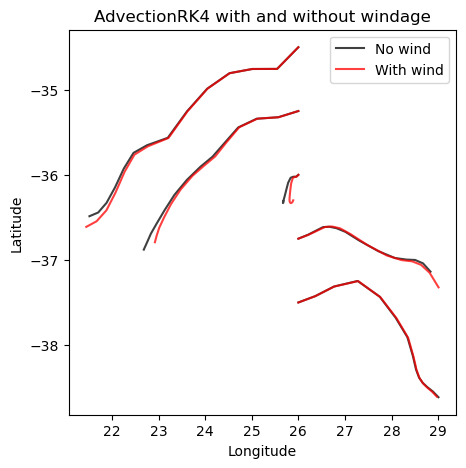

In [20]:
# Now compare the results to when no windage is applied
ds_nowind = xr.open_zarr(f"output/AdvectionRK4_dt_{dt.seconds}s.zarr")
ds_wind = xr.open_zarr("output/WindDriftKernel.zarr")
fig = plt.figure(figsize=(5,5))
plt.title('AdvectionRK4 with and without windage')
nowind_labels = ["No wind"] + [None] * (ds_nowind.lon.shape[0] - 1)
wind_labels = ["With wind"] + [None] * (ds_wind.lon.shape[0] - 1)
plt.plot(ds_nowind.lon.T, ds_nowind.lat.T, alpha=0.75, color='black', label=nowind_labels)
plt.plot(ds_wind.lon.T, ds_wind.lat.T, alpha=0.75, color='red', label=wind_labels)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

### What happens if we use the "relative wind" instead of the "absolute wind"?
Because our particle is already moving in the ocean, the wind it "feels" is not the sampled wind $u_\text{w}$, rather, it is the "relative" wind $u_\text{w} - u$. An equation to describe this particle velocity is $\mathbf{v}_\text{p} = \mathbf{u} + \alpha (\mathbf{u}_\text{w}-\mathbf{u})$. Construct a "relative wind" kernel, and compare the results.

In [21]:
# Let's define a relative wind-drift kernel using an Euler-forward scheme
def RelativeWindDriftKernel(particle, fieldset, time):
    # A relative wind-drift kernel that applies a percentage of wind to each particle
    (uocean, vocean) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
    particle_dlon += particle.windage_coefficient * (fieldset.UWind[particle] - uocean) * particle.dt
    particle_dlat += particle.windage_coefficient * (fieldset.VWind[particle] - vocean) * particle.dt

In [22]:
# Let's create a particle set, and use a windage of 3%
pset = parcels.ParticleSet(fieldset,
                           pclass=WindParticle,
                           lon=initial_release_lons,
                           lat=initial_release_lats,
                           windage_coefficient=0.03*np.ones_like(initial_release_lons))

output_file = pset.ParticleFile(name="output/RelativeWindDriftKernel.zarr", outputdt=outputdt)
pset.execute(
    [parcels.AdvectionRK4, RelativeWindDriftKernel],
    runtime=runtime,
    dt=dt,
    output_file=output_file,
)

INFO: Output files are stored in output/RelativeWindDriftKernel.zarr.
100%|██████████| 604800.0/604800.0 [00:00<00:00, 1041781.94it/s]


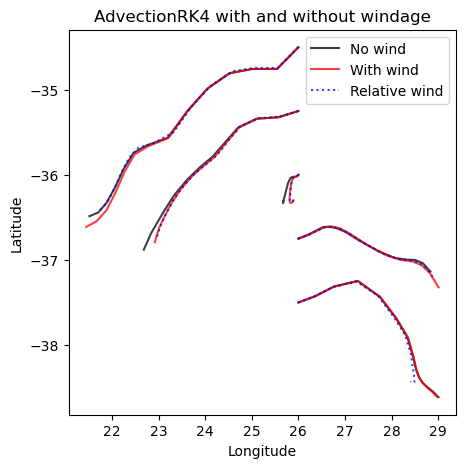

In [24]:
# Now compare the results to when no windage is applied
ds_nowind = xr.open_zarr(f"output/AdvectionRK4_dt_{dt.seconds}s.zarr")
ds_wind = xr.open_zarr("output/WindDriftKernel.zarr")
ds_relwind = xr.open_zarr("output/RelativeWindDriftKernel.zarr")
fig = plt.figure(figsize=(5,5))
plt.title('AdvectionRK4 with and without windage')
nowind_labels = ["No wind"] + [None] * (ds_nowind.lon.shape[0] - 1)
wind_labels = ["With wind"] + [None] * (ds_wind.lon.shape[0] - 1)
relwind_labels = ["Relative wind"] + [None] * (ds_relwind.lon.shape[0] - 1)
plt.plot(ds_nowind.lon.T, ds_nowind.lat.T, alpha=0.75, color='black', label=nowind_labels)
plt.plot(ds_wind.lon.T, ds_wind.lat.T, alpha=0.75, color='red', label=wind_labels)
plt.plot(ds_relwind.lon.T, ds_relwind.lat.T, alpha=0.75, color='blue', linestyle=':', label=relwind_labels)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

### Not all particles are 'pushed' in the direction of the wind...
If particles are non-spherical, they may tend to drift at an angle to the wind (like blue bottles in Australia!). Let's implement a relative wind-drift kernel that incorporates an angled drift term.

We can write this mathematically using a rotation matrix $R$. If the (2D) particle velocity is given by:
\begin{align*}
\mathbf{v}_\text{p} = \mathbf{u} + \alpha R (\mathbf{u}_\text{w}-\mathbf{u}),
\end{align*}

where $R = \begin{bmatrix} \cos(\theta) & -\sin(\theta) \\ \sin(\theta) & \cos(\theta) \end{bmatrix}$ is the rotation matrix, then, we can write each velocity component out as:

\begin{align*}
u_\text{p} &= u + \alpha(\cos(\theta)(u_\text{w} - u) -\sin(\theta)(v_\text{w}-v)), \\
v_\text{p} &= v + \alpha(\sin(\theta)(u_\text{w} - u) +\cos(\theta)(v_\text{w}-v)).
\end{align*}

Let's create a kernel for this!

In [ ]:
def AngledRelativeWindDriftKernel(particle, fieldset, time):
    angle = particle.windangle # in degrees
    angle_rad = math.pi*(angle)/180. # Annoyingly math.radians doesn't work in JIT...

    uwind = fieldset.UWind[particle]
    vwind = fieldset.VWind[particle]
    (uocean, vocean) = fieldset.UV[particle]

    particle_dlon += particle.windage_coefficient * (math.cos(angle_rad) * (uwind - uocean) - math.sin(angle_rad) * (vwind - vocean)) * particle.dt
    particle_dlat += particle.windage_coefficient * (math.sin(angle_rad) * (uwind - uocean) + math.cos(angle_rad) * (vwind - vocean)) * particle.dt

In [ ]:
# Let's create a particle set, and use a windage of 3%
# and wind pushes the particles with a 20deg angle

pset = parcels.ParticleSet(fieldset,
                           pclass=WindParticle,
                           lon=initial_release_lons,
                           lat=initial_release_lats,
                           windage_coefficient=0.03*np.ones_like(initial_release_lons),
                           windangle=20.0*np.ones_like(initial_release_lons))
output_file = pset.ParticleFile(name="output/AngledRelativeWindDriftKernel.zarr", outputdt=outputdt)
pset.execute(
    [parcels.AdvectionRK4, AngledRelativeWindDriftKernel],
    runtime=runtime,
    dt=dt,
    output_file=output_file,
)

INFO: Output files are stored in output/AngledRelativeWindDriftKernel.zarr.
100%|██████████| 604800.0/604800.0 [00:00<00:00, 926879.40it/s] 


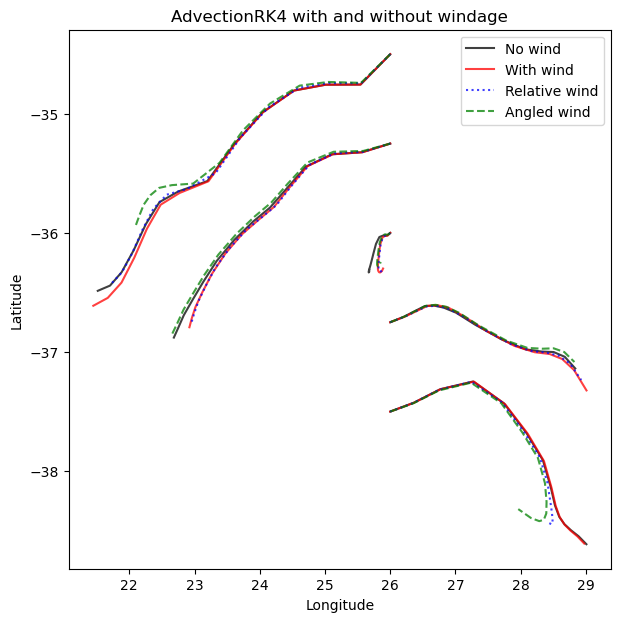

In [ ]:
# Now compare the results to when no windage is applied
ds_nowind = xr.open_zarr(f"output/AdvectionRK4_dt_{dt.seconds}s.zarr")
ds_wind = xr.open_zarr("output/WindDriftKernel.zarr")
ds_relwind = xr.open_zarr("output/RelativeWindDriftKernel.zarr")
ds_angwind = xr.open_zarr("output/AngledRelativeWindDriftKernel.zarr")


fig = plt.figure(figsize=(7,7))
plt.title('AdvectionRK4 with and without windage')
nowind_labels = ["No wind"] + [None] * (ds_nowind.lon.shape[0] - 1)
wind_labels = ["With wind"] + [None] * (ds_wind.lon.shape[0] - 1)
relwind_labels = ["Relative wind"] + [None] * (ds_relwind.lon.shape[0] - 1)
angwind_labels = ["Angled wind"] + [None] * (ds_angwind.lon.shape[0] - 1)
plt.plot(ds_nowind.lon.T, ds_nowind.lat.T, alpha=0.75, color='black', label=nowind_labels)
plt.plot(ds_wind.lon.T, ds_wind.lat.T, alpha=0.75, color='red', label=wind_labels)
plt.plot(ds_relwind.lon.T, ds_relwind.lat.T, alpha=0.75, color='blue', linestyle=':', label=relwind_labels)
plt.plot(ds_angwind.lon.T, ds_angwind.lat.T, alpha=0.75, color='green', linestyle='--', label=angwind_labels)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()